In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("train.csv",delimiter = ",");
print(data.shape);

(10980, 12)


In [3]:
x = data["text"];
y = data["airline_sentiment"];
print(x.shape,y.shape);

(10980,) (10980,)


In [4]:
print(x.head());

0    @SouthwestAir I am scheduled for the morning, ...
1    @SouthwestAir seeing your workers time in and ...
2    @united Flew ORD to Miami and back and  had gr...
3       @SouthwestAir @dultch97 that's horse radish 😤🐴
4    @united so our flight into ORD was delayed bec...
Name: text, dtype: object


In [5]:
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords as sw,wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
lemmatizer = WordNetLemmatizer();

In [6]:
import string
punc = list(string.punctuation);
stopwords = sw.words("english");
stopwords += punc;
airlines = ["SouthwestAir","united","JetBlue","USAirways","AmericanAir","VirginAmerica"];
airlines = ' '.join(airlines).lower().split();
stopwords += airlines;

In [7]:
def getpos(tag):
    if(tag.startswith("J")):
        return wordnet.ADJ;
    elif(tag.startswith("N")):
        return wordnet.NOUN;
    elif(tag.startswith("V")):
        return wordnet.VERB;
    elif(tag.startswith("R")):
        return wordnet.ADV;
    else:
        return wordnet.NOUN;

In [8]:
def cleanwords(sentence):
    sentence = word_tokenize(sentence);
    finalwords = []
    for word in sentence:
        if (word.lower() not in stopwords):
            postag = getpos(pos_tag([word])[0][1]);
            finalword = lemmatizer.lemmatize(word,pos = postag);
            finalwords.append(finalword.lower());
    return ' '.join(finalwords);

In [9]:
x = x.apply(cleanwords);
print(x.head());

0    schedule morning 2 day fact yes .. sure even f...
1    see worker time time go beyond love fly guy thank
2    flew ord miami back great crew service leg thanks
3                          dultch97 's horse radish 😤🐴
4    flight ord delayed air force one last flight s...
Name: text, dtype: object


In [10]:
from sklearn.model_selection import train_test_split,GridSearchCV
xtrain,xtest,ytrain,ytest = train_test_split(x,y);
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape);

(8235,) (8235,) (2745,) (2745,)


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer(max_features = 4000,min_df = 0.01,max_df = 0.99,ngram_range = (1,3));
xtrain = countvec.fit_transform(xtrain);
xtest = countvec.transform(xtest);
print(len(countvec.get_feature_names_out()));

165


In [12]:
print(countvec.get_feature_names_out());

['10' '30' 'aa' 'agent' 'airline' 'airport' 'already' 'amp' 'another'
 'answer' 'anything' 'appreciate' 'ask' 'back' 'bad' 'bag' 'baggage'
 'best' 'board' 'boarding' 'book' 'ca' 'call' 'cancelled'
 'cancelled flighted' 'cancelled flightled' 'change' 'check' 'co' 'come'
 'connection' 'could' 'crew' 'customer' 'customer service' 'day' 'delay'
 'delayed' 'dfw' 'dm' 'due' 'email' 'even' 'ever' 'experience' 'find'
 'first' 'flight' 'flight cancelled' 'flighted' 'flightled' 'flightr'
 'fly' 'follow' 'gate' 'get' 'give' 'go' 'good' 'great' 'guy' 'help'
 'hold' 'home' 'hope' 'hotel' 'hour' 'hr' 'http' 'http co' 'info' 'issue'
 'jfk' 'keep' 'know' 'land' 'last' 'late' 'late flight' 'late flightr'
 'leave' 'left' 'let' 'like' 'line' 'll' 'long' 'look' 'lose' 'love'
 'luggage' 'make' 'mile' 'min' 'minute' 'miss' 'morning' 'much' 'need'
 'never' 'new' 'next' 'night' 'number' 'one' 'online' 'passenger' 'pay'
 'people' 'phone' 'plane' 'please' 'problem' 're' 'really' 'refund'
 'reservation' 'respons

In [14]:
from sklearn.svm import SVC
clf = SVC();
grid = {'C' : [1e3,5e3,1e4,5e4],"gamma" : [1e-3,5e-3,1e-4,5e-4]};
gcv = GridSearchCV(clf,grid);
gcv.fit(xtrain,ytrain);
clf = gcv.best_estimator_;
clf.fit(xtrain,ytrain);
score = clf.score(xtest,ytest);
print(score);

0.7329690346083789


In [15]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
ypred = clf.predict(xtest);
score = accuracy_score(ytest,ypred);
print(score);

0.7329690346083789


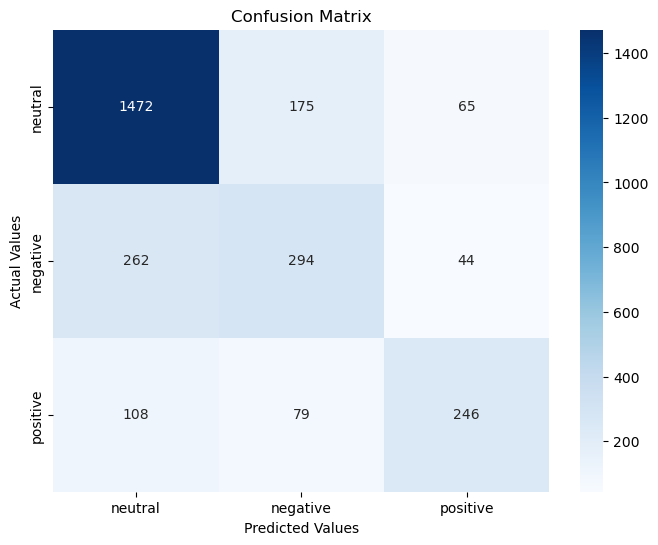

In [16]:
import seaborn as sns 
from matplotlib import pyplot as plt
arr = list(set(ytrain));
plt.figure(figsize = (8,6));
cm = confusion_matrix(ytest,ypred);
sns.heatmap(cm,annot = True,cmap = "Blues",fmt = "d",
            xticklabels = arr,
            yticklabels = arr);
plt.title("Confusion Matrix");
plt.xlabel("Predicted Values");
plt.ylabel("Actual Values");

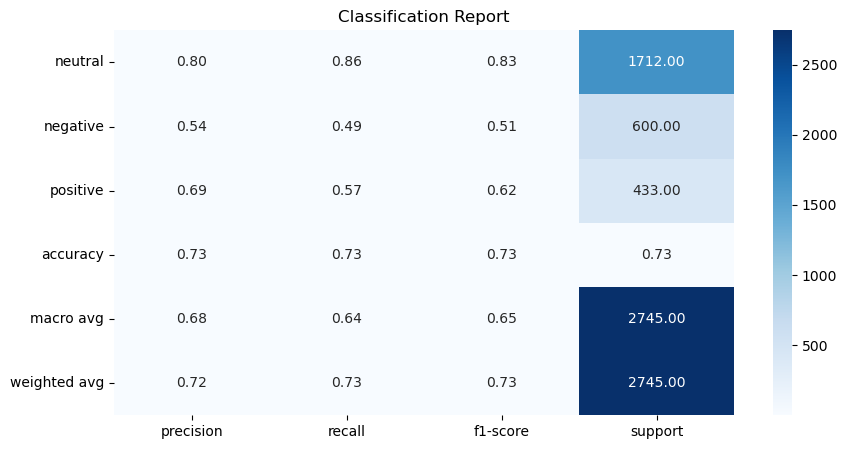

In [17]:
report = classification_report(ytest,ypred,output_dict = True,target_names = arr);
df = pd.DataFrame(report).transpose();
plt.figure(figsize = (10,5));
sns.heatmap(df,annot = True,fmt = ".2f",cmap = "Blues");
plt.title("Classification Report");

In [20]:
testdata = pd.read_csv("test.csv",delimiter = ",");
xtest = testdata["text"];
xtest = countvec.transform(xtest);

In [24]:
ypred = clf.predict(xtest);
np.savetxt("Results.csv",ypred,fmt = "%s");